In [23]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
from itertools import combinations     # biblioteca para realizar iterações ou looping
from tqdm import tqdm                  # biblioteca que gerar display de progresso de cargas ou processamentos
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import sqrt

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
get_ipython().run_line_magic("matplotlib", "inline")


In [24]:
#Carrega dados do Excel no daframe pandas
df_ibov = pd.read_excel("IBOV.xlsx")

In [25]:
# Obtém a primeira coluna e adiciona ".SA" ao final dos valores
yh_ticker = df_ibov.iloc[:,0].astype(str) + ".SA"

In [26]:
lst_ativos = yh_ticker.tolist()

In [38]:
inicio="2019-12-31"
fim="2023-05-19"

In [39]:
dados = yf.download(lst_ativos, inicio, fim)["Adj Close"]


[*********************100%***********************]  87 of 87 completed


In [41]:
#Calcula os retornos das ações
returns = np.log(dados / dados.shift(1))
returns = returns.dropna()


In [42]:
#Primeira Abordagem para Identificar os Pares Cointegrados
columns=dados.columns #coleta dados das colunas (ações)
ativos=[]
for col in columns:
    try:
        X = dados[col].values
        result = adfuller(X)        
        if result[1]>0.1 and result[0]>list(result[4].values())[1]:
            ativos.append(col)
    except:
        print("erro",col)
#print("1) Percentual de Ativos Não Estacionários: %.2f" % (100*len(ativos)/len(columns)),'%')

erro ASAI3.SA
erro BPAC11.SA
erro CASH3.SA
erro CMIN3.SA
erro ENGI11.SA
erro IGTI11.SA
erro KLBN11.SA
erro LWSA3.SA
erro PETZ3.SA
erro RAIZ4.SA
erro RDOR3.SA
erro RRRP3.SA
erro SANB11.SA
erro SOMA3.SA
erro TAEE11.SA


In [43]:
#Realiza combinações de pares
from itertools import combinations 
comb_ativos = list(combinations(ativos, 2)) #criar lista de pares de ativos combinados
print("2) Foram "+str(len(ativos))+" ativos Não Estacionários, de um total de "+str(len(columns))+
      ", com a formação "+str(len(comb_ativos))+" Pares para avaliação de cointegração")

2) Foram 50 ativos Não Estacionários, de um total de 87, com a formação 1225 Pares para avaliação de cointegração


In [44]:
#Encontra pares cointegrados
import statsmodels.api as sm

pairs_coint_1=[]

for comb in tqdm(comb_ativos):
    
    model = sm.OLS(exog=dados[comb[0]],endog=dados[comb[1]]).fit()
    result = adfuller(model.resid)
    
    if result[1]<0.02:# and result[0]>list(result[4].values())[1]:
        pairs_coint_1.append(comb)     
print("3) Foram encontrados "+str(len(pairs_coint_1))+" pares cointegrados entre um total de "+str(len(comb_ativos))+
      " pares de avaliação, perfazendo "+str(round(100*len(pairs_coint_1)/len(comb_ativos),2))+' % da amostra')

100%|██████████| 1225/1225 [00:27<00:00, 43.86it/s]

3) Foram encontrados 25 pares cointegrados entre um total de 1225 pares de avaliação, perfazendo 2.04 % da amostra


In [45]:
pairs_coint_1

[('ARZZ3.SA', 'ELET3.SA'),
 ('B3SA3.SA', 'EZTC3.SA'),
 ('BBAS3.SA', 'CPLE6.SA'),
 ('BBAS3.SA', 'ENBR3.SA'),
 ('BBAS3.SA', 'EQTL3.SA'),
 ('BBAS3.SA', 'HYPE3.SA'),
 ('BBAS3.SA', 'WEGE3.SA'),
 ('BBSE3.SA', 'CIEL3.SA'),
 ('BEEF3.SA', 'CPFE3.SA'),
 ('BEEF3.SA', 'HYPE3.SA'),
 ('BOVA11.SA', 'TOTS3.SA'),
 ('CIEL3.SA', 'CMIG4.SA'),
 ('CIEL3.SA', 'CPFE3.SA'),
 ('CIEL3.SA', 'EQTL3.SA'),
 ('CIEL3.SA', 'WEGE3.SA'),
 ('CPFE3.SA', 'HYPE3.SA'),
 ('CPLE6.SA', 'ENBR3.SA'),
 ('CSAN3.SA', 'ENEV3.SA'),
 ('CSAN3.SA', 'TOTS3.SA'),
 ('CSAN3.SA', 'VBBR3.SA'),
 ('ENEV3.SA', 'SUZB3.SA'),
 ('ENEV3.SA', 'VBBR3.SA'),
 ('GGBR4.SA', 'SLCE3.SA'),
 ('RENT3.SA', 'SUZB3.SA'),
 ('SUZB3.SA', 'VBBR3.SA')]

In [ ]:
# 2.2) Segunda Abordagem para Identificar os Pares Cointegrados

In [47]:
from statsmodels.tsa.stattools import coint
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            X = data[keys[i]]
            Y = data[keys[j]]
            result = coint(X, Y)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

score_matrix, pvalue_matrix, pairs_coint_2 = find_cointegrated_pairs(dados[ativos])

print("Foram encontrados "+str(len(pairs_coint_2))+" pares cointegrados em um total de "+str(len(comb_ativos))+
      " pares possíveis, perfazendo "+str(round(100*len(pairs_coint_2)/len(comb_ativos),2))+' % da amostra')

#https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a

100%|██████████| 50/50 [00:40<00:00,  1.22it/s]

Foram encontrados 45 pares cointegrados em um total de 1225 pares possíveis, perfazendo 3.67 % da amostra


In [48]:
# 2.3) Identificação dos Pares Cointegrados Comuns às duas Abordagens
ativos_LS=list(set(pairs_coint_1)&set(pairs_coint_2))
(ativos_LS)

[('BOVA11.SA', 'TOTS3.SA'),
 ('BBAS3.SA', 'ENBR3.SA'),
 ('CSAN3.SA', 'ENEV3.SA'),
 ('CPLE6.SA', 'ENBR3.SA'),
 ('BBAS3.SA', 'CPLE6.SA'),
 ('BBAS3.SA', 'EQTL3.SA'),
 ('CSAN3.SA', 'VBBR3.SA')]

In [49]:
#2.5) Ordenação dos Pares quanto ao Indice de Correlação

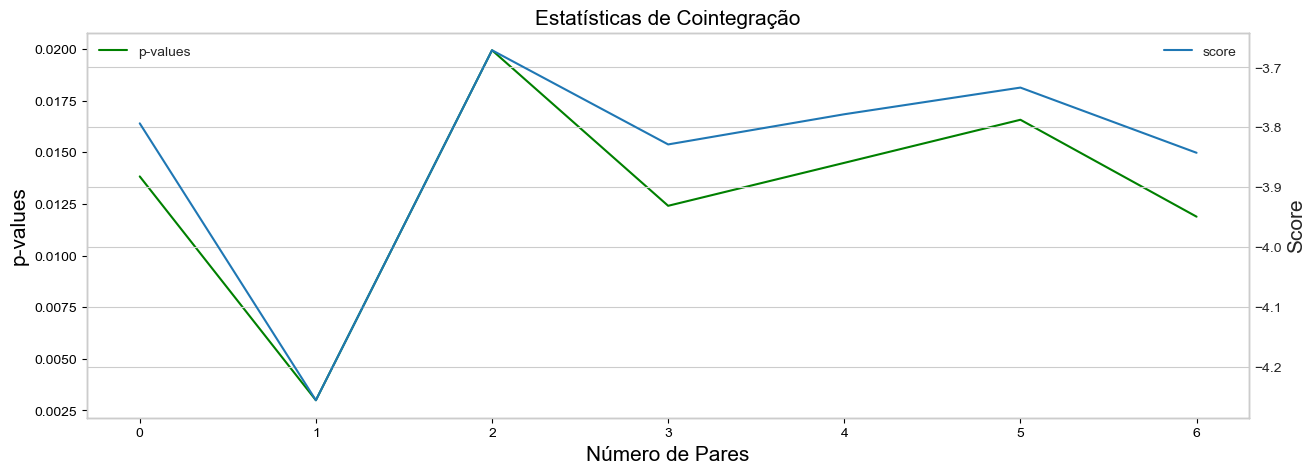

In [50]:
def cointegrated_pairs(data,lista):
    res=[]
    for pair in lista:
        X = data[pair[0]]
        Y = data[pair[1]]
        result = coint(X, Y)
        res.append([result[0],result[1]])
    return res

score_pvalues=pd.DataFrame(cointegrated_pairs(dados,ativos_LS))
fig = plt.subplots(figsize=(15,5))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(111)
ax1.plot(score_pvalues[1],c='g',label='p-values')
ax1.set_ylabel('p-values',fontsize=15)
ax1.set_xlabel("Número de Pares",fontsize=15)
ax1.set_title("Estatísticas de Cointegração",fontsize=15)
ax12 = ax1.twinx()
ax12.plot(score_pvalues[0],label='score')
ax12.set_ylabel("Score",fontsize=15)
ax1.legend(loc='upper left')
ax12.legend(loc='upper right')

In [51]:
#2.5) Ordenação dos Pares quanto ao Indice de Correlação

In [52]:
from scipy.stats.stats import pearsonr   
ip=[]
for par in ativos_LS:
    X = dados[par[0]]
    Y = dados[par[1]]
    ip.append([pearsonr(X,Y)[0],par])

In [53]:
pd.DataFrame(ip).sort_values(by=0, ascending=False)

0                      1
3  0.907456   (CPLE6.SA, ENBR3.SA)
1  0.809674   (BBAS3.SA, ENBR3.SA)
2  0.802687   (CSAN3.SA, ENEV3.SA)
0  0.775333  (BOVA11.SA, TOTS3.SA)
6  0.767098   (CSAN3.SA, VBBR3.SA)
4  0.708847   (BBAS3.SA, CPLE6.SA)
5  0.675999   (BBAS3.SA, EQTL3.SA)

In [54]:
ativos_LS=(pd.DataFrame(ip).sort_values(by=0, ascending=False)[1].values)
ativos_LS

array([('CPLE6.SA', 'ENBR3.SA'), ('BBAS3.SA', 'ENBR3.SA'),
       ('CSAN3.SA', 'ENEV3.SA'), ('BOVA11.SA', 'TOTS3.SA'),
       ('CSAN3.SA', 'VBBR3.SA'), ('BBAS3.SA', 'CPLE6.SA'),
       ('BBAS3.SA', 'EQTL3.SA')], dtype=object)

In [55]:
# 2.6) Apresentação do Residos dos PAres Cointegrados

100%|██████████| 7/7 [00:00<00:00, 16.60it/s]


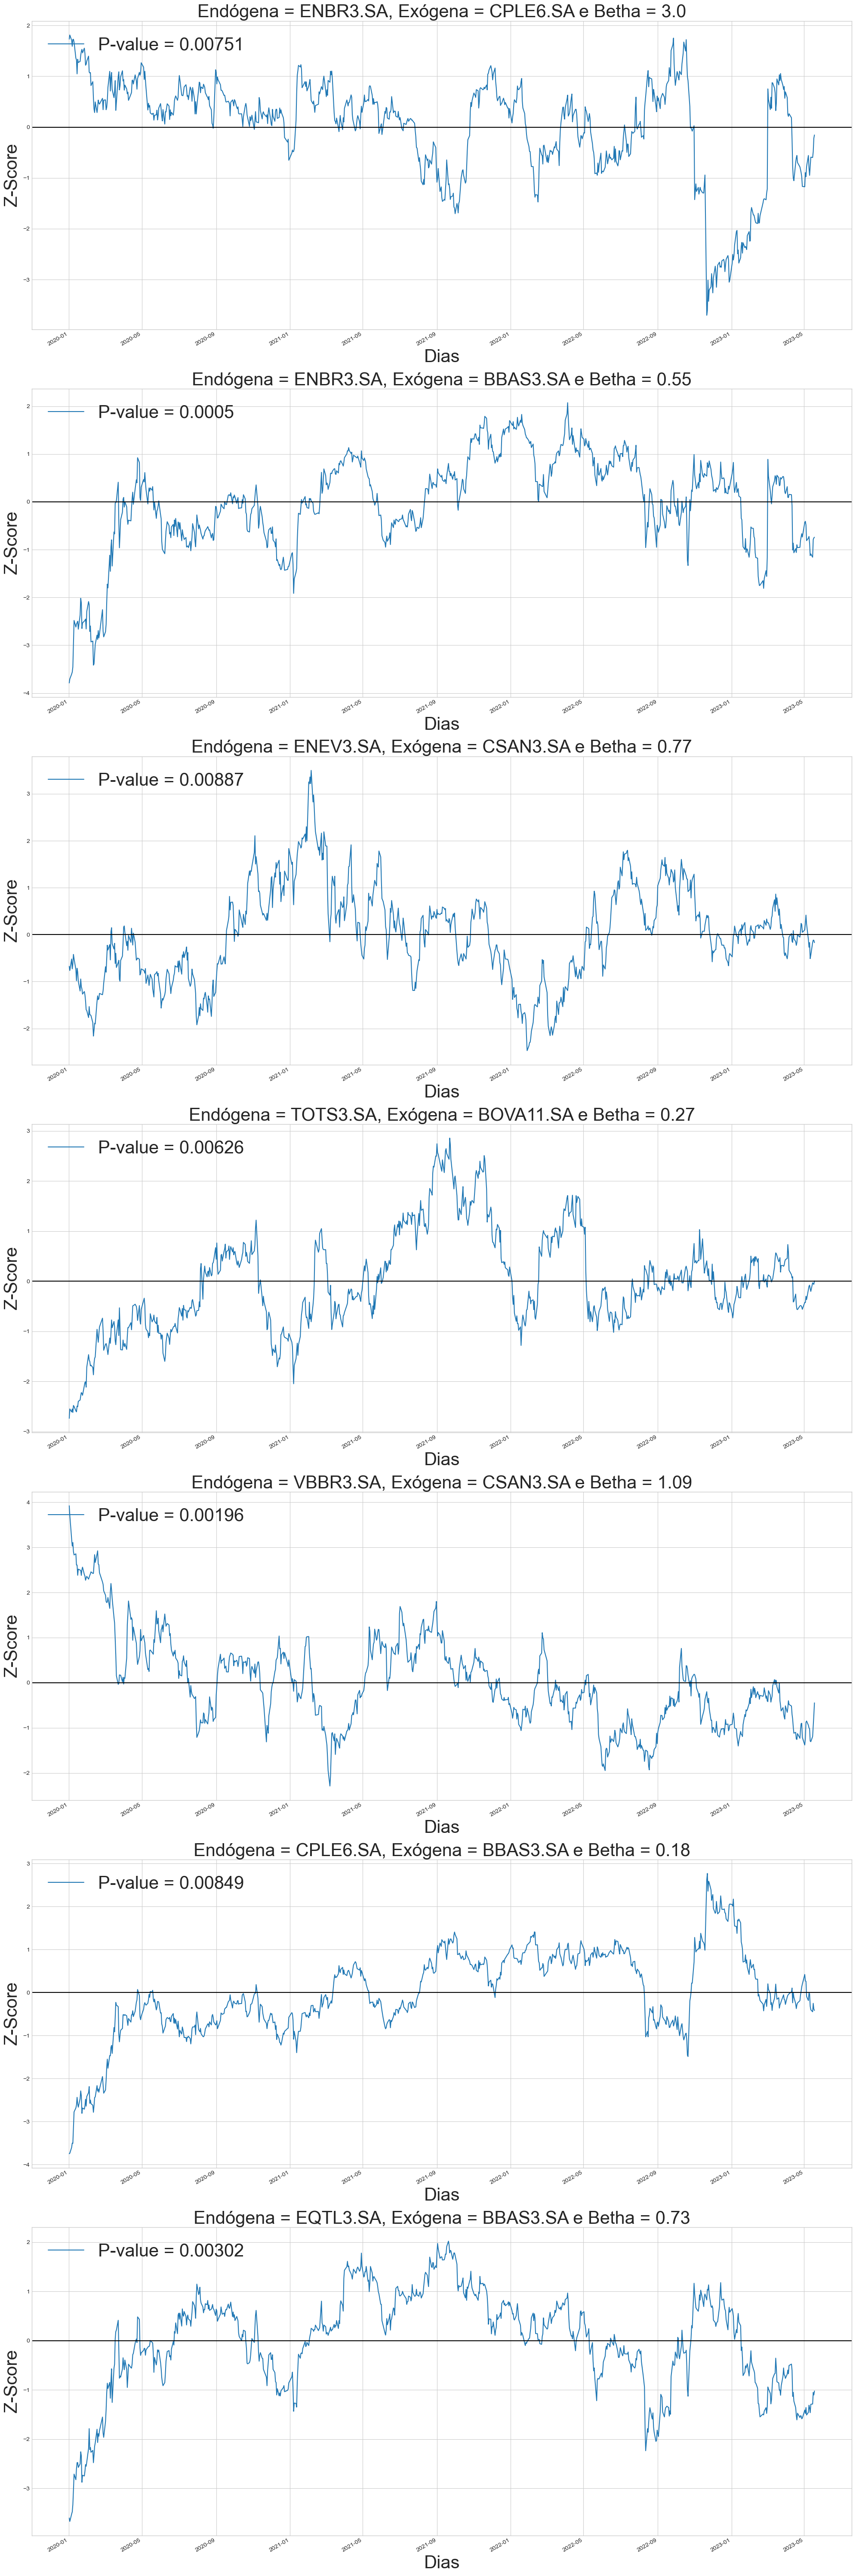

In [56]:
fig = plt.subplots(figsize=(20,60))
plt.style.use('seaborn-whitegrid')

for i in tqdm(range(0,len(ativos_LS))):
 #   print(i)
    #ax1 = plt.subplot(len(ativos_LS)+len(ativos_LS)%3,3,i+1)
    ax1 = plt.subplot(len(ativos_LS),1,i+1)
    X = dados[ativos_LS[i][0]]
    Y = dados[ativos_LS[i][1]]

 #   score, pvalue, _ = coint(S1, S2)
 #   print(pvalue)
    
    model = sm.OLS(endog=Y,exog=X).fit()
    resid=model.resid   
    
    p = adfuller(model.resid)[1]
    residzc=(resid-resid.mean())/resid.std()
    residzc.plot(label='P-value = '+str(round(p,5)))
    plt.axhline(residzc.mean(),color="k")
   # ratios = S1 / S2
   # ratios.plot()
   # plt.axhline(ratios.mean())
    plt.legend(loc="upper left",fontsize=30) 
 #   plt.show()
   
    plt.ylabel('Z-Score', fontsize=30) 
    plt.xlabel('Dias', fontsize=30) 
    plt.title("Endógena = "+ ativos_LS[i][1]+", Exógena = "+ativos_LS[i][0]+" e Betha = "+str(round(model.params.values[0],2)), fontsize=30) 
plt.tight_layout()

In [57]:
#Identificação dos Resultados de Trades Long & Short dentro da Amostra

100%|██████████| 7/7 [00:00<00:00,  8.42it/s]


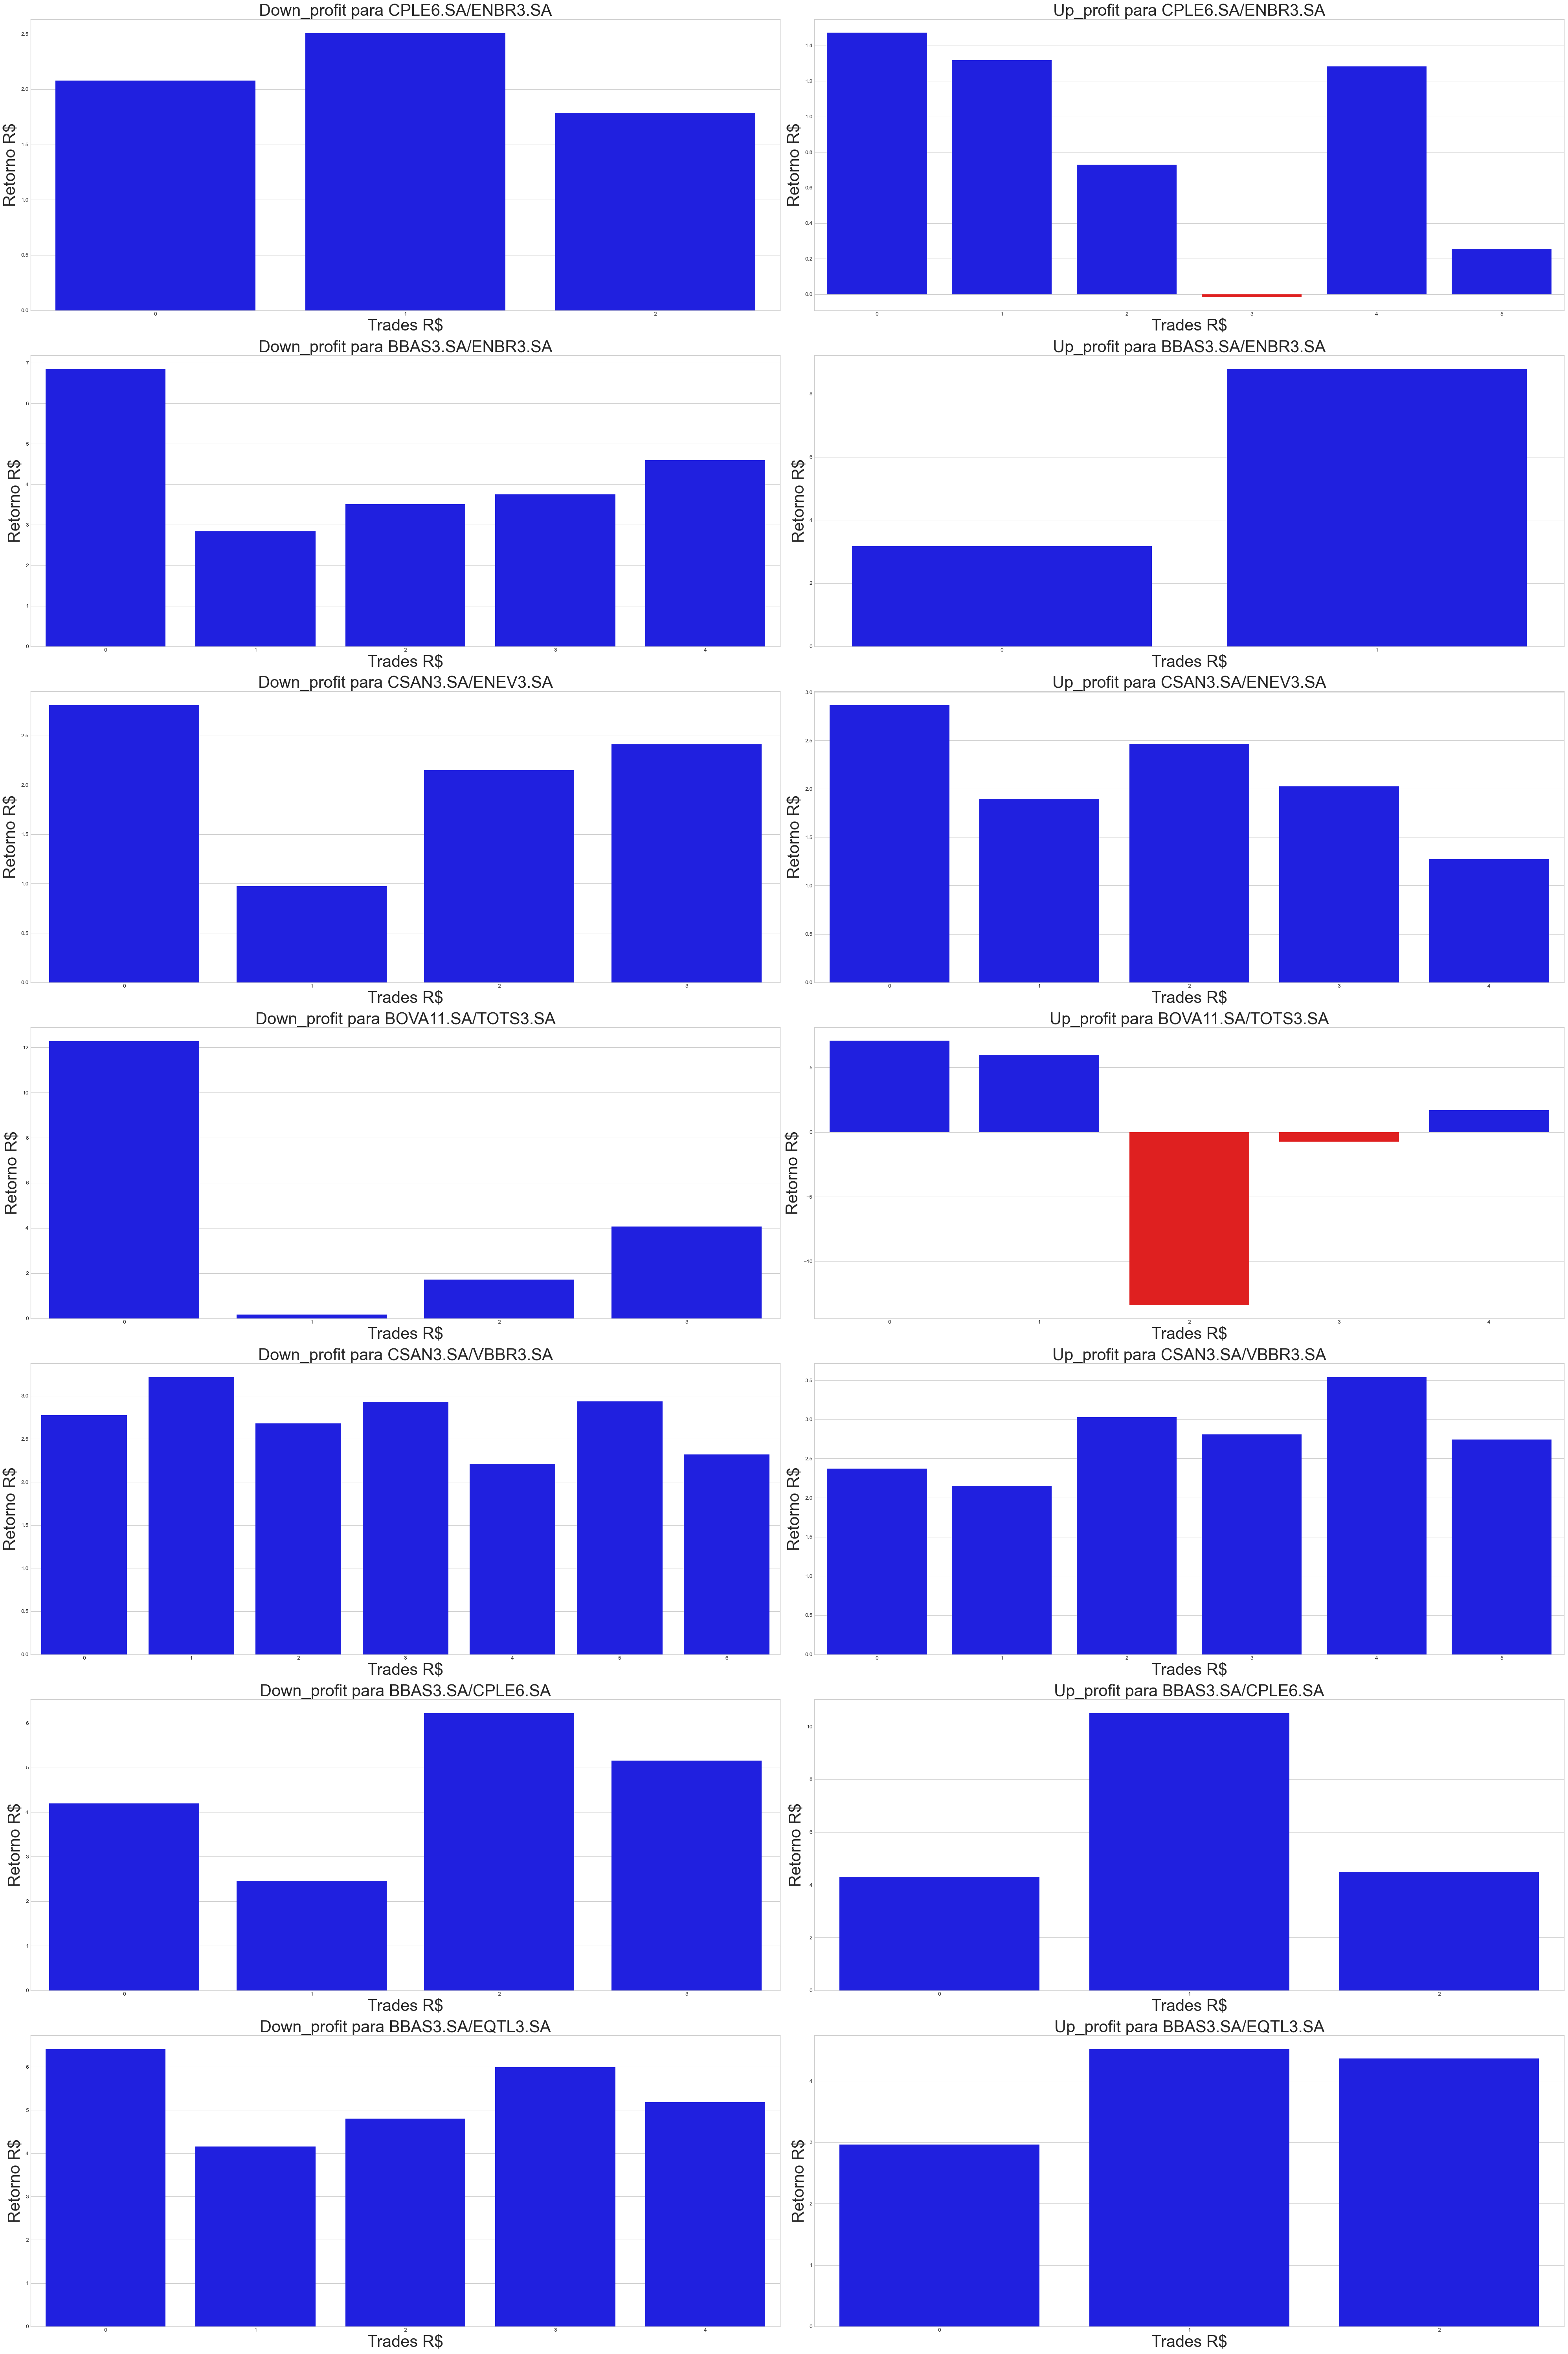

In [58]:
fig, ax = plt.subplots(figsize=(40, 60))
down_profit=[]
up_profit=[]
perna = 100000
for i in tqdm(range(0,len(ativos_LS))):
    
    X = dados[ativos_LS[i][0]]
    Y = dados[ativos_LS[i][1]]
    model = sm.OLS(exog=X,endog=Y).fit()
    resid=model.resid 
    LS = pd.DataFrame(index=dados.index)
    LS["X"]=X
    LS["Y"]=Y
    betha=model.params[0]
    LS["residuo"]=(resid-resid.mean())/resid.std()

    LS['signal_open_down']=0
    LS['signal_open_up']=0
    desvio=1.0
    sinal_open_down=[]
    sinal_open_up=[]
    open_down=0
    open_up=0
    for day in range(1,len(LS)): 
        

        open_down_1  = LS['residuo'].iloc[day-1] > -desvio
        open_down_2  = LS['residuo'].iloc[day]   < -desvio
        close_down_1 = LS['residuo'].iloc[day-1] < 0
        close_down_2 = LS['residuo'].iloc[day]   > 0

        if open_down_1 & open_down_2:
            open_down = -1
        if (open_down == -1) & close_down_1 & close_down_2:
            open_down = 0        
        sinal_open_down.append(open_down)    

        open_up_1  = LS['residuo'].iloc[day-1] < desvio
        open_up_2  = LS['residuo'].iloc[day]   > desvio
        close_up_1 = LS['residuo'].iloc[day-1] > 0
        close_up_2 = LS['residuo'].iloc[day]   < 0

        if open_up_1 & open_up_2:
            open_up = 1
        if (open_up == 1) & close_up_1 & close_up_2:
            open_up = 0        
        sinal_open_up.append(open_up)       
        
    LS.loc[1:,'signal_open_down']=sinal_open_down
    LS.loc[1:,'signal_open_up']=sinal_open_up
        
 #   LS['signal_open_down'].iloc[1:]=sinal_open_down
 #   LS['signal_open_up'].iloc[1:]=sinal_open_up

    Pos_start_down=np.where(LS["signal_open_down"].diff()<0)[0]
    Pos_close_down=np.where(LS["signal_open_down"].diff()>0)[0]
    len_down=np.min([len(Pos_start_down),len(Pos_close_down)])

    if betha>0:
        Y_down_profit=+(LS["Y"].iloc[Pos_close_down].values[:len_down]-LS["Y"].iloc[Pos_start_down].values[:len_down])
        X_down_profit=-(LS["X"].iloc[Pos_close_down].values[:len_down]-LS["X"].iloc[Pos_start_down].values[:len_down])
    else:
        Y_down_profit=+(LS["Y"].iloc[Pos_close_down].values[:len_down]-LS["Y"].iloc[Pos_start_down].values[:len_down])
        X_down_profit=+(LS["X"].iloc[Pos_close_down].values[:len_down]-LS["X"].iloc[Pos_start_down].values[:len_down])

    perna_y_açoes_down=[int(peso-peso%100) for peso in perna/LS["Y"].iloc[Pos_start_down].values[:len_down]]
    perna_x_açoes_down=[int(peso-peso%100) for peso in perna/LS["X"].iloc[Pos_start_down].values[:len_down]]

    down_profit.append([ativos_LS[i][0],ativos_LS[i][1],
                        X_down_profit,Y_down_profit,
                        perna_x_açoes_down,perna_y_açoes_down,
                        Pos_start_down,Pos_close_down,
                        LS["X"],LS["Y"],
                        LS['residuo'],betha])

    Pos_start_up=np.where(LS["signal_open_up"].diff()>0)[0]
    Pos_close_up=np.where(LS["signal_open_up"].diff()<0)[0]
    len_up=np.min([len(Pos_start_up),len(Pos_close_up)])

    if betha>0:
        Y_up_profit=-(LS["Y"].iloc[Pos_close_up].values[:len_up]-LS["Y"].iloc[Pos_start_up].values[:len_up])
        X_up_profit=+(LS["X"].iloc[Pos_close_up].values[:len_up]-LS["X"].iloc[Pos_start_up].values[:len_up])
    else:
        Y_up_profit=-(LS["Y"].iloc[Pos_close_up].values[:len_up]-LS["Y"].iloc[Pos_start_up].values[:len_up])
        X_up_profit=-(LS["X"].iloc[Pos_close_up].values[:len_up]-LS["X"].iloc[Pos_start_up].values[:len_up])
        

    perna_y_açoes_up=[int(peso-peso%100) for peso in perna/LS["Y"].iloc[Pos_start_up].values[:len_up]]
    perna_x_açoes_up=[int(peso-peso%100) for peso in perna/LS["X"].iloc[Pos_start_up].values[:len_up]]

    up_profit.append([ativos_LS[i][0],ativos_LS[i][1],
                      X_up_profit,Y_up_profit,
                      perna_x_açoes_up,perna_y_açoes_up,
                      Pos_start_up,Pos_close_up,
                      LS["X"],LS["Y"],
                      LS['residuo'],betha])
    
    plt.style.use('seaborn-whitegrid')
    #ax1 = plt.subplot(len(ativos_LS)+len(ativos_LS)%3,3,i+1)
    ax1 = plt.subplot(len(ativos_LS),2,2*i+1)
    #values = Y_down_profit*perna_y_açoes_down+X_down_profit*perna_x_açoes_down
    #values = Y_down_profit+betha*X_down_profit
    values = Y_down_profit+X_down_profit
    idx = np.array(list(range(len(values)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in values]
    sns.barplot(x=idx, y=values, palette=clrs,label=ativos_LS[i][0]+"/"+ativos_LS[i][1]) 
    plt.ylabel('Retorno R$', fontsize=30)
    plt.xlabel('Trades R$', fontsize=30)
    plt.title("Down_profit para "+ativos_LS[i][0]+"/"+ativos_LS[i][1], fontsize=30) 

    ax1 = plt.subplot(len(ativos_LS),2,2*i+2)
    #ax1 = plt.subplot(len(ativos_LS)+len(ativos_LS)%3,3,i+1)
    #values = Y_up_profit*perna_y_açoes_up+X_up_profit*perna_x_açoes_up
    #values = Y_up_profit+betha*X_up_profit 
    values = Y_up_profit+X_up_profit 
    idx = np.array(list(range(len(values)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in values]
    sns.barplot(x=idx, y=values, palette=clrs,label=ativos_LS[i][0]+"/"+ativos_LS[i][1]) 
    plt.ylabel('Retorno R$', fontsize=30)
    plt.xlabel('Trades R$', fontsize=30)
    plt.title("Up_profit para "+ativos_LS[i][0]+"/"+ativos_LS[i][1], fontsize=30) 
    
plt.tight_layout()  

100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


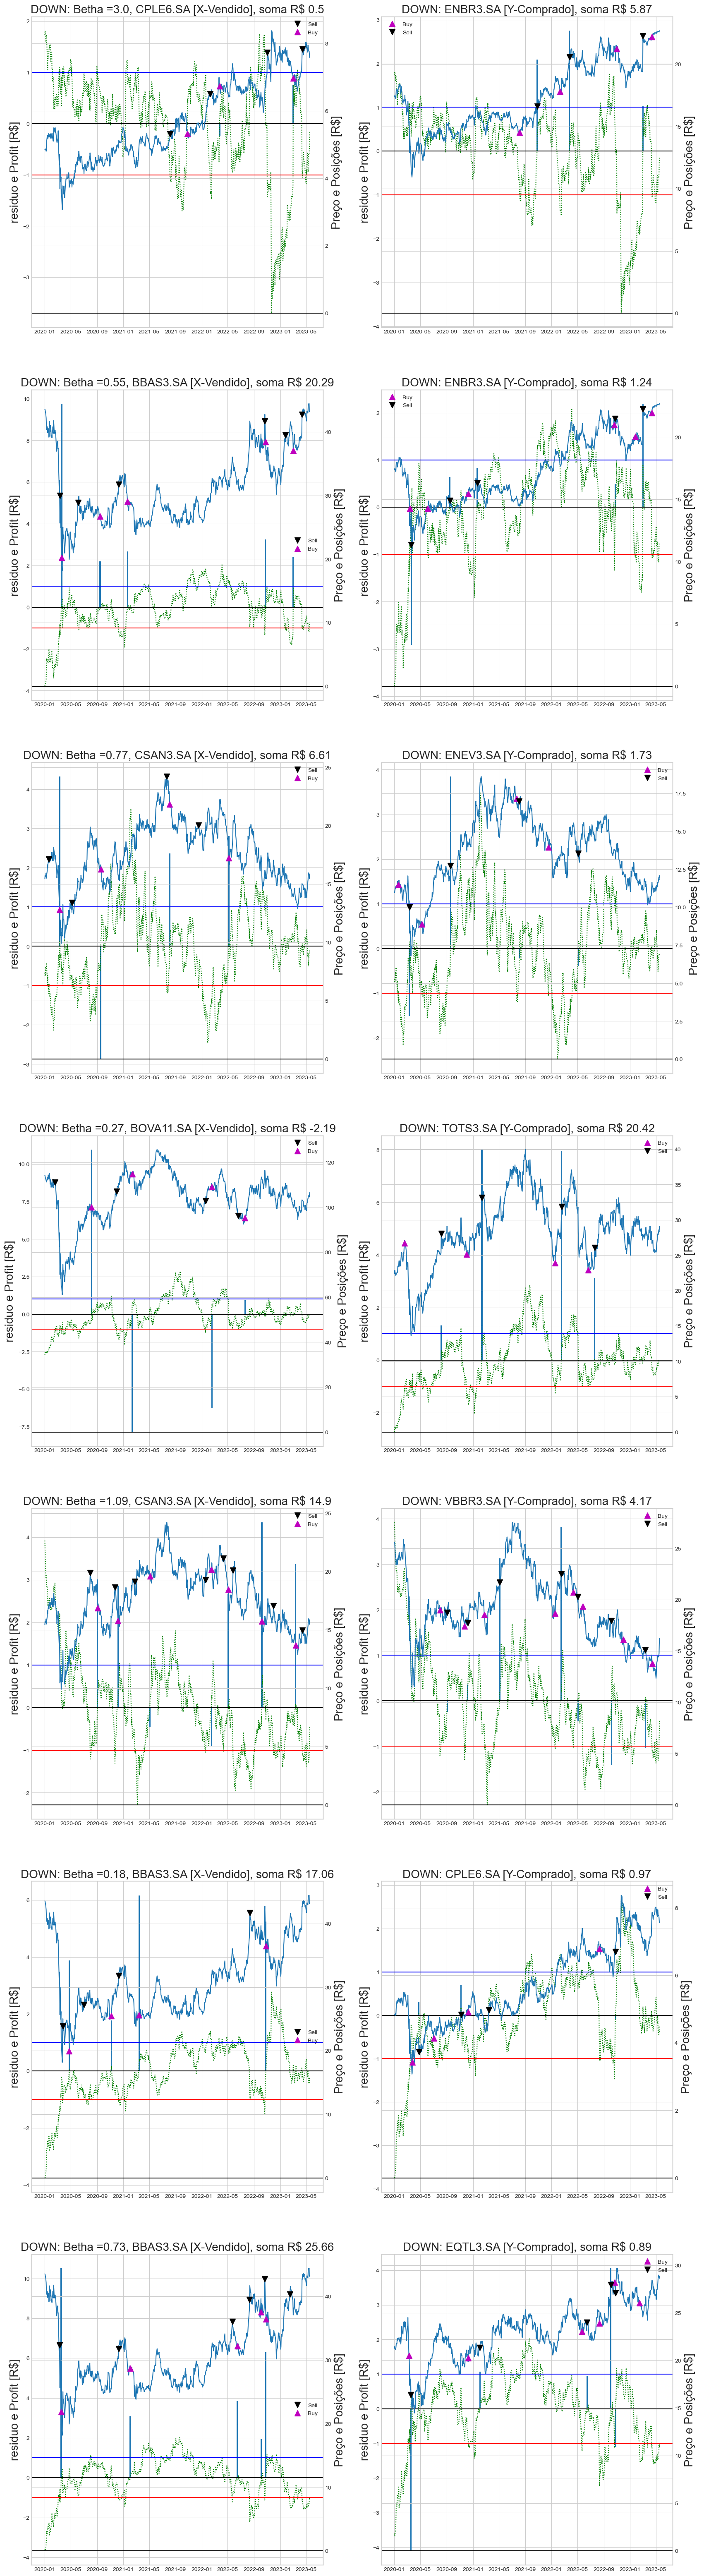

In [59]:
fig, ax1 = plt.subplots(figsize=(20, 80))
i=1
for i in tqdm(range(len(down_profit))):
    ax1 = plt.subplot(len(ativos_LS),2,2*i+1)
    ax1.bar(down_profit[i][8].iloc[down_profit[i][7]].index[:len(down_profit[i][2])], down_profit[i][2],width=6) 
    ax1.plot(down_profit[i][10].index,down_profit[i][10],"g:")
    ax1.axhline(y=-1.0, color='r', linestyle='-')
    ax1.axhline(y=1.0, color='b', linestyle='-')
    ax1.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("residuo e Profit [R$]", fontsize=20)
    ax2 = ax1.twinx() 
    ax2.plot(down_profit[i][8].index,down_profit[i][8])
    ax2.plot(down_profit[i][8].iloc[down_profit[i][6]].index, down_profit[i][8].iloc[down_profit[i][6]],'v', markersize=10, color='k',label='Sell')
    ax2.plot(down_profit[i][8].iloc[down_profit[i][7]].index, down_profit[i][8].iloc[down_profit[i][7]],'^', markersize=10, color='m',label='Buy') 
    ax2.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("Preço e Posições [R$]", fontsize=20)
    plt.legend()
    plt.title("DOWN: Betha ="+str(round(down_profit[i][-1],2))+", "+down_profit[i][0]+" [X-Vendido]"+", soma R$ "+str(round(np.sum(down_profit[i][2]),2)), fontsize=20)

    ax1 = plt.subplot(len(ativos_LS),2,2*i+2)
    ax1.bar(down_profit[i][9].iloc[down_profit[i][7]].index[:len(down_profit[i][3])], down_profit[i][3],width=6) 
    ax1.plot(down_profit[i][10].index,down_profit[i][10],"g:")
    ax1.axhline(y=-1.0, color='r', linestyle='-')
    ax1.axhline(y=1.0, color='b', linestyle='-')
    ax1.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("residuo e Profit [R$]", fontsize=20)
    ax2 = ax1.twinx() 
    ax2.plot(down_profit[i][9].index,down_profit[i][9])
    ax2.plot(down_profit[i][9].iloc[down_profit[i][6]].index, down_profit[i][9].iloc[down_profit[i][6]],'^', markersize=10, color='m',label='Buy')
    ax2.plot(down_profit[i][9].iloc[down_profit[i][7]].index, down_profit[i][9].iloc[down_profit[i][7]],'v', markersize=10, color='k',label='Sell') 
    ax2.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("Preço e Posições [R$]", fontsize=20)
    plt.legend()
    plt.title("DOWN: "+down_profit[i][1]+" [Y-Comprado]"+", soma R$ "+str(round(np.sum(down_profit[i][3]),2)), fontsize=20)

100%|██████████| 7/7 [00:00<00:00, 10.00it/s]


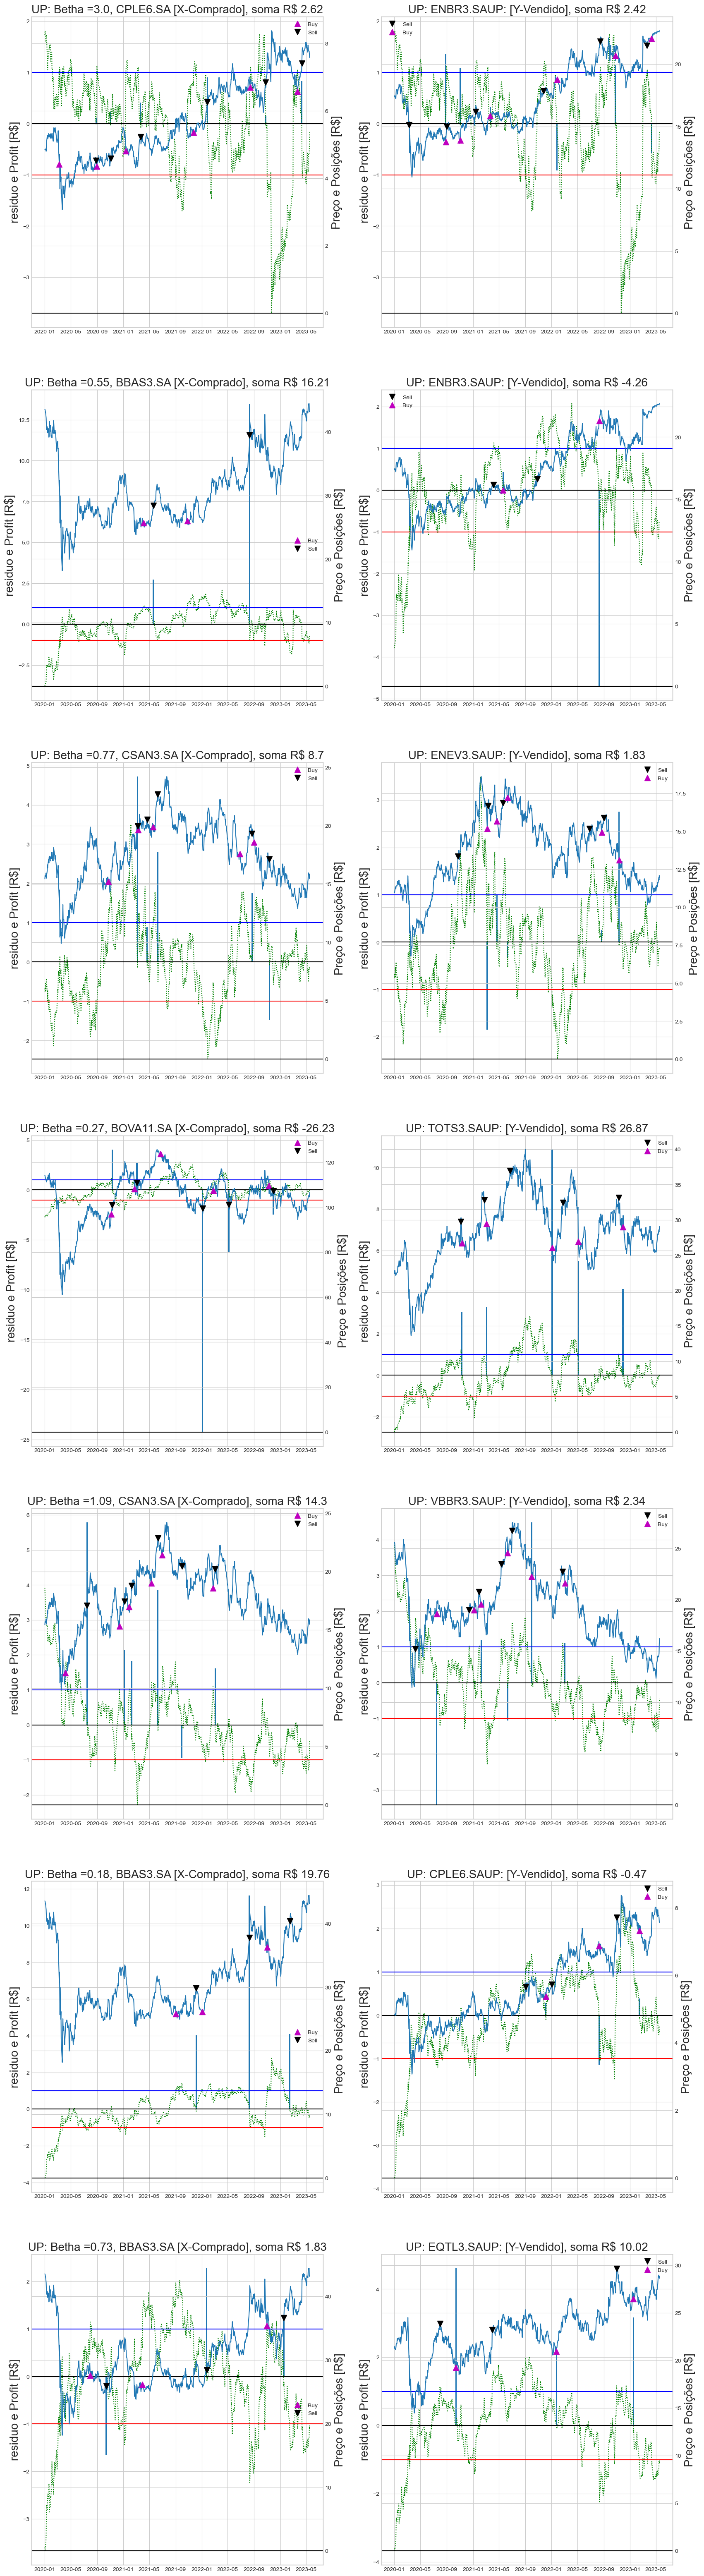

In [60]:
fig, ax1 = plt.subplots(figsize=(20, 80))
i=1
for i in tqdm(range(len(up_profit))):
    ax1 = plt.subplot(len(ativos_LS),2,2*i+1)
    ax1.bar(up_profit[i][8].iloc[up_profit[i][7]].index[:len(up_profit[i][2])], up_profit[i][2],width=6) 
    ax1.plot(up_profit[i][10].index,up_profit[i][10],"g:")
    ax1.axhline(y=-1.0, color='r', linestyle='-')
    ax1.axhline(y=1.0, color='b', linestyle='-')
    ax1.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("residuo e Profit [R$]", fontsize=20)
    ax2 = ax1.twinx() 
    ax2.plot(up_profit[i][8].index,up_profit[i][8])
    ax2.plot(up_profit[i][8].iloc[up_profit[i][6]].index, up_profit[i][8].iloc[up_profit[i][6]],'^', markersize=10, color='m',label='Buy')
    ax2.plot(up_profit[i][8].iloc[up_profit[i][7]].index, up_profit[i][8].iloc[up_profit[i][7]],'v', markersize=10, color='k',label='Sell') 
    ax2.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("Preço e Posições [R$]", fontsize=20)
    plt.legend()
    plt.title("UP: Betha ="+str(round(up_profit[i][-1],2))+", "+up_profit[i][0]+" [X-Comprado]"+", soma R$ "+str(round(np.sum(up_profit[i][2]),2)), fontsize=20)

    ax1 = plt.subplot(len(ativos_LS),2,2*i+2)
    ax1.bar(up_profit[i][9].iloc[up_profit[i][7]].index[:len(up_profit[i][3])], up_profit[i][3],width=6) 
    ax1.plot(up_profit[i][10].index,up_profit[i][10],"g:")
    ax1.axhline(y=-1.0, color='r', linestyle='-')
    ax1.axhline(y=1.0, color='b', linestyle='-')
    ax1.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("residuo e Profit [R$]", fontsize=20)
    ax2 = ax1.twinx() 
    ax2.plot(up_profit[i][9].index,up_profit[i][9])
    ax2.plot(up_profit[i][9].iloc[up_profit[i][6]].index, up_profit[i][9].iloc[up_profit[i][6]],'v', markersize=10, color='k',label='Sell')
    ax2.plot(up_profit[i][9].iloc[up_profit[i][7]].index, up_profit[i][9].iloc[up_profit[i][7]],'^', markersize=10, color='m',label='Buy') 
    ax2.axhline(y=0.0, color='k', linestyle='-')
    plt.ylabel("Preço e Posições [R$]", fontsize=20)
    plt.legend()
    plt.title("UP: "+up_profit[i][1]+"UP: [Y-Vendido]"+", soma R$ "+str(round(np.sum(up_profit[i][3]),2)), fontsize=20)

In [61]:
#3.1) Assumindo Ajuste com o Betha

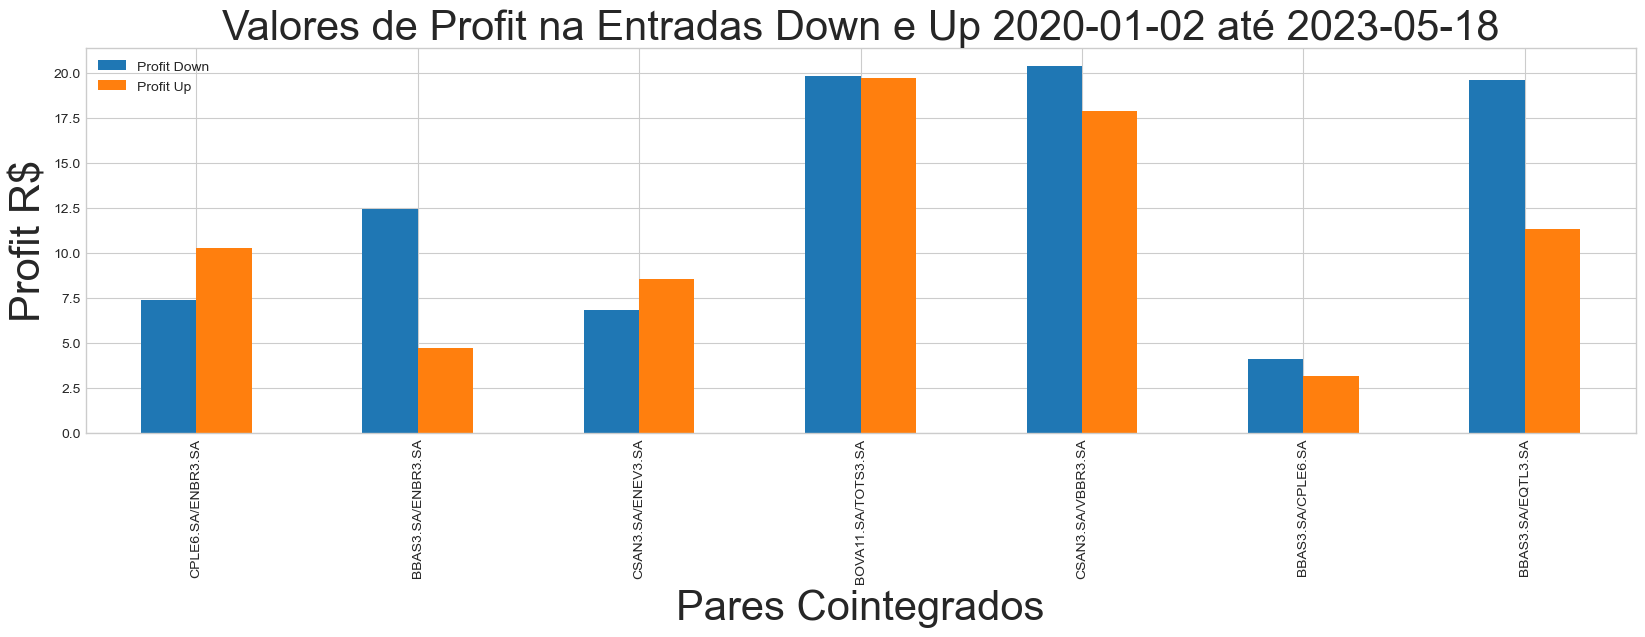

In [62]:
result=[]
for i in range(len(down_profit)):
    #pf_down=np.sum(down_profit[i][2]*down_profit[i][4]+down_profit[i][3]*down_profit[i][5])
    #pf_up=np.sum(up_profit[i][2]*up_profit[i][4]+up_profit[i][3]*up_profit[i][5])
    pf_down=np.sum(down_profit[i][3]+down_profit[i][-1]*down_profit[i][2])
    pf_up=np.sum(up_profit[i][3]+up_profit[i][-1]*up_profit[i][2])
    
    result.append([down_profit[i][0]+"/"+down_profit[i][1],pf_down,pf_up])
result=pd.DataFrame(result,columns=["Par","Profit Down", "Profit Up"]).set_index("Par")    
result.plot(kind='bar',figsize=(20, 5))
plt.xlabel("Pares Cointegrados",fontsize=30) 
plt.ylabel("Profit R$",fontsize=30) 
plt.title("Valores de Profit na Entradas Down e Up "+str(dados.index[0])[:10]+" até "+str(dados.index[-1])[:10],fontsize=30) 
plt.show()    

In [63]:
#Executa teste de cointegrações e detecta pares cointegrados
pairs = []
num_acoes = len(lst_ativos)

for i in range(num_acoes):
    for j in range(i + 1, num_acoes):
        stock1 = returns.iloc[:, i]
        stock2 = returns.iloc[:, j]
        result = sm.OLS(stock1, stock2).fit()
        pvalue = sm.tsa.stattools.adfuller(result.resid)[1]
        
        if pvalue < 0.05:
            pairs.append((lst_ativos[i], lst_ativos[j]))


In [64]:
#lista pares cointegrados e indica quem comprar e quem vender
for pair in pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    price1 = dados[stock1]
    price2 = dados[stock2]
    
    spread = price1 - price2
    zscore = (spread - spread.mean()) / spread.std()
    
    # Aplicar as regras de negociação (exemplo):
    if zscore[-1] > 1.0:
        # Realizar uma operação de venda curta no par
        print(f"Venda curta: {stock1} e compra: {stock2}")
    elif zscore[-1] < -1.0:
        # Realizar uma operação de compra no par
        print(f"Compra: {stock1} e venda curta: {stock2}")


Venda curta: RRRP3.SA e compra: ALPA4.SA
Compra: RRRP3.SA e venda curta: BBSE3.SA
Compra: RRRP3.SA e venda curta: BBAS3.SA
Compra: RRRP3.SA e venda curta: BPAC11.SA
Compra: RRRP3.SA e venda curta: CCRO3.SA
Compra: RRRP3.SA e venda curta: CMIG4.SA
Compra: RRRP3.SA e venda curta: CIEL3.SA
Compra: RRRP3.SA e venda curta: CPLE6.SA
Compra: RRRP3.SA e venda curta: CPFE3.SA
Compra: RRRP3.SA e venda curta: CMIN3.SA
Compra: RRRP3.SA e venda curta: ELET6.SA
Compra: RRRP3.SA e venda curta: EMBR3.SA
Compra: RRRP3.SA e venda curta: ENBR3.SA
Compra: RRRP3.SA e venda curta: ENGI11.SA
Compra: RRRP3.SA e venda curta: EGIE3.SA
Compra: RRRP3.SA e venda curta: EQTL3.SA
Compra: RRRP3.SA e venda curta: GGBR4.SA
Compra: RRRP3.SA e venda curta: GOAU4.SA
Compra: RRRP3.SA e venda curta: HYPE3.SA
Compra: RRRP3.SA e venda curta: IGTI11.SA
Compra: RRRP3.SA e venda curta: ITSA4.SA
Compra: RRRP3.SA e venda curta: ITUB4.SA
Compra: RRRP3.SA e venda curta: KLBN11.SA
Compra: RRRP3.SA e venda curta: RENT3.SA
Compra: RRRP

Compra: BRAP4.SA e venda curta: RADL3.SA
Compra: BRAP4.SA e venda curta: SMTO3.SA
Compra: BRAP4.SA e venda curta: TAEE11.SA
Compra: BRAP4.SA e venda curta: WEGE3.SA
Venda curta: BBAS3.SA e compra: BRKM5.SA
Venda curta: BBAS3.SA e compra: BRFS3.SA
Venda curta: BBAS3.SA e compra: BPAC11.SA
Venda curta: BBAS3.SA e compra: CRFB3.SA
Venda curta: BBAS3.SA e compra: CCRO3.SA
Venda curta: BBAS3.SA e compra: CMIG4.SA
Venda curta: BBAS3.SA e compra: CIEL3.SA
Venda curta: BBAS3.SA e compra: COGN3.SA
Venda curta: BBAS3.SA e compra: CPLE6.SA
Venda curta: BBAS3.SA e compra: CSAN3.SA
Venda curta: BBAS3.SA e compra: CPFE3.SA
Venda curta: BBAS3.SA e compra: CMIN3.SA
Venda curta: BBAS3.SA e compra: CVCB3.SA
Venda curta: BBAS3.SA e compra: CYRE3.SA
Venda curta: BBAS3.SA e compra: DXCO3.SA
Venda curta: BBAS3.SA e compra: ELET3.SA
Venda curta: BBAS3.SA e compra: ELET6.SA
Venda curta: BBAS3.SA e compra: EMBR3.SA
Venda curta: BBAS3.SA e compra: ENBR3.SA
Venda curta: BBAS3.SA e compra: ENGI11.SA
Venda curta: 

Venda curta: CSAN3.SA e compra: HAPV3.SA
Compra: CSAN3.SA e venda curta: IGTI11.SA
Compra: CSAN3.SA e venda curta: ITSA4.SA
Compra: CSAN3.SA e venda curta: ITUB4.SA
Venda curta: CSAN3.SA e compra: JBSS3.SA
Compra: CSAN3.SA e venda curta: KLBN11.SA
Compra: CSAN3.SA e venda curta: RENT3.SA
Venda curta: CSAN3.SA e compra: LREN3.SA
Venda curta: CSAN3.SA e compra: MRFG3.SA
Compra: CSAN3.SA e venda curta: MULT3.SA
Compra: CSAN3.SA e venda curta: PETR3.SA
Compra: CSAN3.SA e venda curta: PETR4.SA
Compra: CSAN3.SA e venda curta: PRIO3.SA
Venda curta: CSAN3.SA e compra: PETZ3.SA
Compra: CSAN3.SA e venda curta: RADL3.SA
Compra: CSAN3.SA e venda curta: SMTO3.SA
Compra: CSAN3.SA e venda curta: TAEE11.SA
Compra: CSAN3.SA e venda curta: TIMS3.SA
Compra: CSAN3.SA e venda curta: WEGE3.SA
Venda curta: CPFE3.SA e compra: CVCB3.SA
Venda curta: CPFE3.SA e compra: DXCO3.SA
Venda curta: CPFE3.SA e compra: ELET3.SA
Venda curta: CPFE3.SA e compra: ENEV3.SA
Venda curta: CPFE3.SA e compra: EZTC3.SA
Venda curta: 

Venda curta: EGIE3.SA e compra: IGTI11.SA
Venda curta: EGIE3.SA e compra: ITSA4.SA
Venda curta: EGIE3.SA e compra: ITUB4.SA
Venda curta: EGIE3.SA e compra: JBSS3.SA
Venda curta: EGIE3.SA e compra: KLBN11.SA
Venda curta: EGIE3.SA e compra: LWSA3.SA
Venda curta: EGIE3.SA e compra: LREN3.SA
Venda curta: EGIE3.SA e compra: MGLU3.SA
Venda curta: EGIE3.SA e compra: MRFG3.SA
Venda curta: EGIE3.SA e compra: CASH3.SA
Venda curta: EGIE3.SA e compra: BEEF3.SA
Venda curta: EGIE3.SA e compra: MRVE3.SA
Compra: EGIE3.SA e venda curta: PETR3.SA
Compra: EGIE3.SA e venda curta: PETR4.SA
Compra: EGIE3.SA e venda curta: PRIO3.SA
Venda curta: EGIE3.SA e compra: PETZ3.SA
Venda curta: EGIE3.SA e compra: RAIZ4.SA
Venda curta: EGIE3.SA e compra: RDOR3.SA
Venda curta: EGIE3.SA e compra: RAIL3.SA
Venda curta: EGIE3.SA e compra: SANB11.SA
Venda curta: EGIE3.SA e compra: CSNA3.SA
Venda curta: EGIE3.SA e compra: SUZB3.SA
Venda curta: EGIE3.SA e compra: VIVT3.SA
Venda curta: EGIE3.SA e compra: TIMS3.SA
Venda curta: 

Venda curta: ITSA4.SA e compra: CASH3.SA
Venda curta: ITSA4.SA e compra: MRVE3.SA
Compra: ITSA4.SA e venda curta: MULT3.SA
Compra: ITSA4.SA e venda curta: PETR3.SA
Compra: ITSA4.SA e venda curta: PETR4.SA
Compra: ITSA4.SA e venda curta: PRIO3.SA
Venda curta: ITSA4.SA e compra: PETZ3.SA
Compra: ITSA4.SA e venda curta: RADL3.SA
Venda curta: ITSA4.SA e compra: RAIZ4.SA
Venda curta: ITSA4.SA e compra: RDOR3.SA
Venda curta: ITSA4.SA e compra: VIIA3.SA
Venda curta: ITSA4.SA e compra: VBBR3.SA
Venda curta: ITSA4.SA e compra: YDUQ3.SA
Venda curta: ITUB4.SA e compra: JBSS3.SA
Venda curta: ITUB4.SA e compra: LWSA3.SA
Venda curta: ITUB4.SA e compra: LREN3.SA
Venda curta: ITUB4.SA e compra: MGLU3.SA
Venda curta: ITUB4.SA e compra: MRFG3.SA
Venda curta: ITUB4.SA e compra: CASH3.SA
Venda curta: ITUB4.SA e compra: MRVE3.SA
Compra: ITUB4.SA e venda curta: MULT3.SA
Compra: ITUB4.SA e venda curta: PETR3.SA
Compra: ITUB4.SA e venda curta: PETR4.SA
Compra: ITUB4.SA e venda curta: PRIO3.SA
Venda curta: ITU

Venda curta: SANB11.SA e compra: VIIA3.SA
Venda curta: SANB11.SA e compra: VBBR3.SA
Venda curta: SANB11.SA e compra: YDUQ3.SA
Venda curta: SMTO3.SA e compra: CSNA3.SA
Venda curta: SMTO3.SA e compra: SUZB3.SA
Venda curta: SMTO3.SA e compra: VIVT3.SA
Venda curta: SMTO3.SA e compra: TOTS3.SA
Venda curta: SMTO3.SA e compra: USIM5.SA
Venda curta: SMTO3.SA e compra: VIIA3.SA
Venda curta: SMTO3.SA e compra: VBBR3.SA
Venda curta: SMTO3.SA e compra: YDUQ3.SA
Compra: CSNA3.SA e venda curta: TAEE11.SA
Compra: CSNA3.SA e venda curta: WEGE3.SA
Compra: SUZB3.SA e venda curta: TAEE11.SA
Compra: SUZB3.SA e venda curta: WEGE3.SA
Venda curta: TAEE11.SA e compra: TOTS3.SA
Venda curta: TAEE11.SA e compra: USIM5.SA
Venda curta: TAEE11.SA e compra: VIIA3.SA
Venda curta: TAEE11.SA e compra: VBBR3.SA
Venda curta: TAEE11.SA e compra: YDUQ3.SA
Venda curta: VIVT3.SA e compra: YDUQ3.SA
Venda curta: TIMS3.SA e compra: VIIA3.SA
Venda curta: TIMS3.SA e compra: VBBR3.SA
Venda curta: TIMS3.SA e compra: YDUQ3.SA
Compra

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [ ]:
symbol_list = ['ABEV3.SA', 'GGBR4.SA', 'ARZZ3.SA', 'MGLU3.SA', 'LREN3.SA', 'PETR3.SA', 'PETR4.SA','VALE3.SA', 'BRAP4.SA']
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

### Encontra pares cointegrados


In [ ]:

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2, maxlag=1)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
# Executa a função que encontra os pares cointegrados
scores, pvalues, pairs = find_cointegrated_pairs(data)

In [ ]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

In [ ]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

In [ ]:
S1

In [ ]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+2', '-2']);